In [1]:
import os
import time
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F

from torchvision import models
from torchvision import datasets, transforms

In [2]:
# Add bias term (column of 1s) to X
def add_bias_term(X):
    return np.c_[np.ones((X.shape[0], 1)), X]

# X.shape[0] gives the number of rows in X.
# np.ones((X.shape[0], 1)) creates a column vector of ones with the same number of rows.
# np.c_ concatenates the column of ones to the original feature matrix X column-wise.

In [3]:
# Initialize weights with X updated to handle bias
def initialize_parameters(X, y, multiclass):
    n_features = X.shape[1]  # Number of features from the input X with bias term
    if multiclass:
        n_classes = y.shape[1]
        theta = np.random.randn(n_features, n_classes) * 0.01  # Small random weights
    else:
        theta = np.random.randn(n_features, 1) * 0.01  # Small random weights
    return theta

In [4]:
# Linear prediction
def linear_prediction(X, theta):
    return np.dot(X, theta)

In [5]:
# Sigmoid function for binary classification
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Softmax function for multi-class
def softmax(z):
    exp_scores = np.exp(z - np.max(z, axis=1, keepdims=True))  # For numerical stability
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

In [6]:
# Binary Cross Entropy Loss
def binary_cross_entropy_loss(y_true, y_pred):
    m = y_true.shape[0]                         # Number of samples
    epsilon = 1e-15                             # To avoid log(0) this is a very small value
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)) / m

# Categorical Cross Entropy Loss
def categorical_cross_entropy_loss(y_true, y_pred):
    m = y_true.shape[0]                         # Number of samples
    epsilon = 1e-15                             # To avoid log(0)
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.sum(y_true * np.log(y_pred)) / m

In [7]:
def gradient_descent_step(X, y, predictions, theta, learning_rate, multiclass):
    m = X.shape[0]
    if multiclass:
        gradients = (1/m) * np.dot(X.T, (predictions - y))
    else:
        gradients = (1/m) * np.dot(X.T, (predictions - y))
    theta = theta - learning_rate * gradients
    return theta

In [8]:
# Stochastic Gradient Descent (SGD) Step
def stochastic_gradient_descent_step(X, y, theta, learning_rate, multiclass):
    m = X.shape[0]
    for i in range(m):
        xi = X[i:i+1]
        yi = y[i:i+1]
        prediction = linear_prediction(xi, theta)
        if multiclass:
            prediction = softmax(prediction)
        else:
            prediction = sigmoid(prediction)
        gradients = np.dot(xi.T, (prediction - yi))
        theta = theta - learning_rate * gradients
    return theta


In [9]:
# Training function
def train_model(X, y, learning_rate=0.01, iterations=1000, batch=True, multiclass=False):
    # Add bias term to X
    X = add_bias_term(X)
    
    # Initialize theta
    theta = initialize_parameters(X, y, multiclass)
    
    # Track loss over iterations
    losses = []
    
    for i in range(iterations):
        # Compute predictions and loss
        if multiclass:
            predictions = softmax(linear_prediction(X, theta))
            loss = categorical_cross_entropy_loss(y, predictions)
        else:
            predictions = sigmoid(linear_prediction(X, theta))
            loss = binary_cross_entropy_loss(y, predictions)
        
        losses.append(loss)
        
        # Update weights
        if batch:
            theta = gradient_descent_step(X, y, predictions, theta, learning_rate, multiclass)
        else:
            # Use stochastic gradient descent
            theta = stochastic_gradient_descent_step(X, y, theta, learning_rate, multiclass)
        
        # Print loss every 100 iterations
        if i % 200 == 0:
            print(f"Iteration {i}/{iterations}, Loss: {loss:.4f}")
    
    return theta, losses

In [10]:
# Set multiclass to True or False
multiclass = True  # Set to True for multiclass classification

if multiclass:
    # For multiclass classification
    X_syn, y_syn = make_classification(n_samples=200, n_features=3, n_informative=3, 
                                   n_redundant=0, n_clusters_per_class=1, n_classes=4, random_state=100)
    # Convert y to one-hot encoding
    y_syn = np.eye(np.max(y_syn) + 1)[y_syn]
else:
    # For binary classification
    X_syn, y_syn = make_classification(n_samples=200, n_features=2, n_classes=2, n_informative=2, n_redundant=0, random_state=100)
    y_syn = y_syn.reshape(-1, 1)  # Reshape y to be a column vector

# Split into training and test sets
X_train_syn, X_test_syn, y_train_syn, y_test_syn = train_test_split(X_syn, y_syn, test_size=0.2, random_state=100)

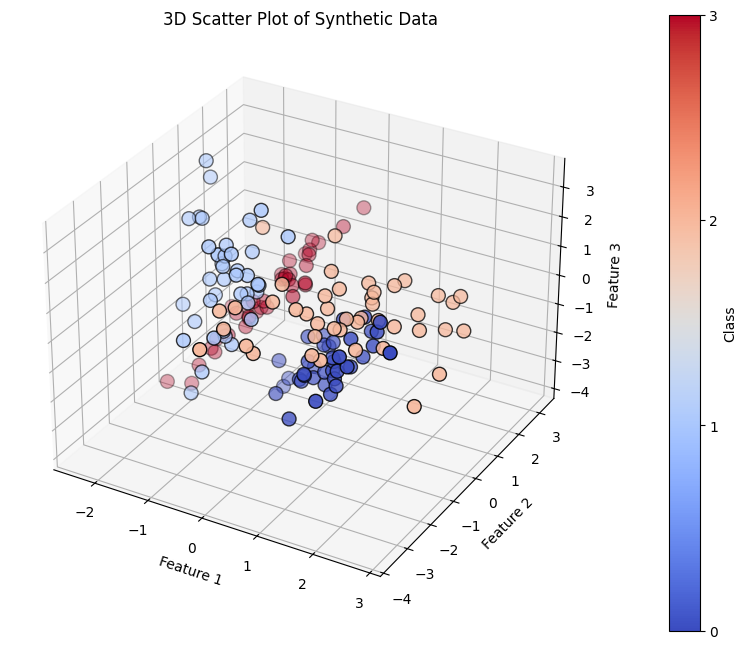

In [11]:
if multiclass:
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    # Convert one-hot encoding to class labels for plotting
    y_train_labels = np.argmax(y_train_syn, axis=1)

    # Use the 3 features for the scatter plot
    scatter = ax.scatter(X_train_syn[:, 0], X_train_syn[:, 1], X_train_syn[:, 2], 
                         c=y_train_labels, cmap='coolwarm', edgecolor='k', s=100)

    # Add labels
    ax.set_title("3D Scatter Plot of Synthetic Data")
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    ax.set_zlabel("Feature 3")

    # Add color bar to represent class labels
    cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
    cbar.set_label('Class')
    
    # Set ticks to be integers corresponding to class labels
    cbar.set_ticks(np.arange(np.min(y_train_labels), np.max(y_train_labels) + 1))

    plt.show()
else:
    plt.figure(figsize=(10, 8))
    plt.scatter(X_train_syn[:, 0], X_train_syn[:, 1], c=y_train_syn, cmap='coolwarm', edgecolor='k', s=100)
    plt.title("Scatter Plot of Training Data")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()
    

In [12]:
start_time = time.time()
theta, losses = train_model(X_train_syn, y_train_syn, learning_rate=0.01, iterations=5000, batch=True, multiclass=multiclass)
print(f"Time Taken Using Batch gradient descent :{time.time() - start_time}")

Iteration 0/5000, Loss: 1.3868
Iteration 200/5000, Loss: 0.7363
Iteration 400/5000, Loss: 0.5602
Iteration 600/5000, Loss: 0.4807
Iteration 800/5000, Loss: 0.4355
Iteration 1000/5000, Loss: 0.4063
Iteration 1200/5000, Loss: 0.3859
Iteration 1400/5000, Loss: 0.3708
Iteration 1600/5000, Loss: 0.3592
Iteration 1800/5000, Loss: 0.3500
Iteration 2000/5000, Loss: 0.3425
Iteration 2200/5000, Loss: 0.3362
Iteration 2400/5000, Loss: 0.3310
Iteration 2600/5000, Loss: 0.3265
Iteration 2800/5000, Loss: 0.3226
Iteration 3000/5000, Loss: 0.3191
Iteration 3200/5000, Loss: 0.3161
Iteration 3400/5000, Loss: 0.3134
Iteration 3600/5000, Loss: 0.3110
Iteration 3800/5000, Loss: 0.3088
Iteration 4000/5000, Loss: 0.3069
Iteration 4200/5000, Loss: 0.3051
Iteration 4400/5000, Loss: 0.3034
Iteration 4600/5000, Loss: 0.3019
Iteration 4800/5000, Loss: 0.3005
Time Taken Using Batch gradient descent :0.53694748878479


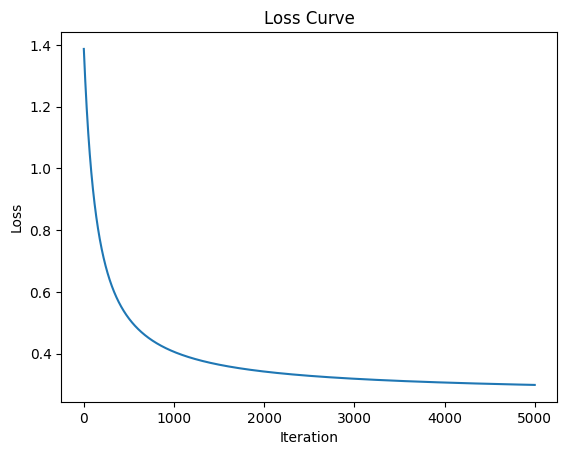

In [13]:
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()

In [14]:
# Add bias term to test data
X_test_bias = add_bias_term(X_test_syn)

if multiclass:
    predictions = softmax(linear_prediction(X_test_bias, theta))
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_test_syn, axis=1)
else:
    predictions = sigmoid(linear_prediction(X_test_bias, theta))
    predicted_classes = (predictions >= 0.5).astype(int)
    true_classes = y_test_syn

# Calculate accuracy
accuracy = np.mean(predicted_classes.flatten() == true_classes.flatten())
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 92.50%
